In [2]:
# pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.4/228.4 MB 557.4 kB/s eta 0:00:0000:0100:13
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 612.7 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 559.7 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 776.0 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 1.1 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 1.3 MB/s eta 0:00:00a 0:00:01
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Preparing metadata (setup.py) ... done
  Using cached absl_py-1.2.0-py3-none-any.whl (123 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.8/960.8 kB 1.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.2 MB/s eta 0:00:0000:0100:01
  Usi

Note: you may need to restart the kernel to use updated packages.


In [3]:
import datetime
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import tensorflow as tf 
from scipy import stats
import pickle5 as pickle

In [ ]:
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# I. Load data

In [172]:
with open("OF_res.pkl","rb") as f:
    OF = pickle.load(f)
    
with open("GPOMS_res.pkl","rb") as f:
    GPOMS = pickle.load(f)
    
DJIA = pd.read_pickle("DJIA_filled_missing_val.pkl")

# 2. Prepare dataset

In [173]:
DJIA_prim = DJIA.copy()

GPOMS_prim = GPOMS.copy()
GPOMS_prim[['Calm','Kind','Happy','Alert','Sure','Vital']] = pd.DataFrame(GPOMS.GPOMS_avg.tolist(), index= GPOMS.index)
GPOMS_prim = GPOMS_prim.drop(['GPOMS_sum', 'GPOMS_avg', 'sum_index', 
                              'avg_index', 'GPOMS_preprocess_data', 'tweet_size', 'tweets_processed'], axis=1)
# GPOMS_prim = GPOMS_prim.rename({'date_processed': 'Dates'}, axis=1) 

DJIA = DJIA_prim.query(' "2022-5-1" <= Dates <= "2022-6-30"').reset_index(drop=True)

GPOMS_ = GPOMS_prim.query(' "2022-05-01" <= date_processed <= "2022-06-30"').reset_index(drop=True)
# GPOMS_ = GPOMS_.drop(columns=['Dates'])

Data = pd.concat([DJIA, GPOMS_], axis=1)

In [174]:
# Data = Data.set_index('Dates')
Data.head()

,Dates,Close,Calm,Kind,Happy,Alert,Sure,Vital
0,2022-05-01,33040.427734,0.113750,0.132750,-0.002000,0.421500,0.104200,-0.211500
1,2022-05-02,33061.500000,0.036875,0.169769,-0.098667,0.329500,0.102600,-0.021833
2,2022-05-03,33128.789062,0.020400,0.093375,-0.163818,0.557714,0.141286,0.215077
3,2022-05-04,34061.058594,0.192500,0.168294,-0.166067,0.447250,0.101750,0.180778
4,2022-05-05,32997.968750,-0.187300,0.138333,-0.159667,0.312538,0.173375,0.140182


# III. Build Neural Network model to predict DJIA
input: 
1. The past 3 days of DJIA values
2. The same combination data of our Opinion Finder mood time series (past 3 days)

Time period (in thesis): 
> Train: 2008-2-28 ~ 2008-11-28 (10 months)

> Test: 2008-12-1 ~ 2008-12-19 (19 days)

Time period (in this project): 
> Train: 2022-5-4 ~ 2022-6-10 (38 days)

> Test: 2022-6-13 ~ 2022-6-30 (17 days)


### Part 1 : 只提供過去三天收盤價資訊

Single variable

> X[0]: [[ [1], [2], [3]]] 

> y[0]: [4]

#### Close price

<AxesSubplot:>

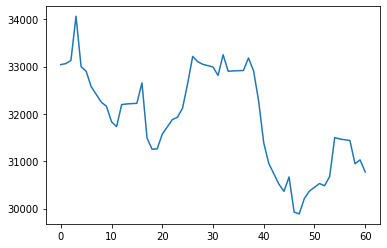

In [175]:
tmp = Data['Close']
tmp.plot()

In [176]:
tmp = tmp.to_numpy().reshape(-1, 1)

scaler = MinMaxScaler()
temp = scaler.fit_transform(tmp)
temp.shape

(61, 1)

In [177]:
def df_to_X_y(df, window_size=3):
    X = []
    y = []
    for i in range(len(df)-window_size):
        row = [a for a in df[i:i+window_size]]
        X.append(row)
        label = df[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [178]:
WINDOW_SIZE = 3
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((58, 3, 1), (58, 1))

In [179]:
threshold = 41

X_train1, y_train1 = X1[:threshold-3], y1[:threshold-3]
X_test1, y_test1 = X1[threshold:], y1[threshold:]
X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape

((38, 3, 1), (38, 1), (17, 3, 1), (17, 1))

In [180]:
model1 = Sequential()
model1.add(InputLayer((3, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear')) #for stock prediction?

model1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 64)                16896     
                                                                 
 dense_24 (Dense)            (None, 8)                 520       
                                                                 
 dense_25 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [181]:
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

model1.fit(X_train1, y_train1, epochs=10)

Epoch 1/10
2/2 [==============================] - 1s 5ms/step - loss: 0.3657 - root_mean_squared_error: 0.6047
Epoch 2/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0623 - root_mean_squared_error: 0.2496
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0641 - root_mean_squared_error: 0.2533
Epoch 4/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0737 - root_mean_squared_error: 0.2714
Epoch 5/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0141 - root_mean_squared_error: 0.1187
Epoch 6/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0328 - root_mean_squared_error: 0.1811
Epoch 7/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0463 - root_mean_squared_error: 0.2152
Epoch 8/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0334 - root_mean_squared_error: 0.1828
Epoch 9/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0165 - root_mean_squared_error: 0.1283
E

2/2 [==============================] - 0s 3ms/step


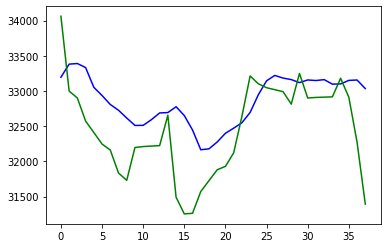

In [182]:
# train result
train_predictions = model1.predict(X_train1).flatten()
pred = scaler.inverse_transform(train_predictions.reshape(-1, 1))
pred = pred.reshape(-1,)
act = scaler.inverse_transform(y_train1)
act = act.reshape(-1,)

train_results1 = pd.DataFrame(data={
    'Train Predictions':pred, 
    'Actuals':act})

plt.plot(train_results1['Train Predictions'], c='b')
plt.plot(train_results1['Actuals'], c='g')

1/1 [==============================] - 0s 22ms/step


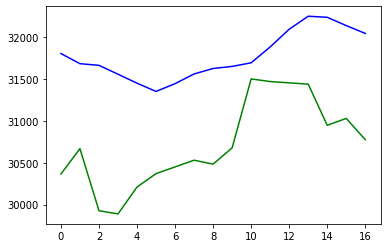

In [183]:
# Test result
test_predictions = model1.predict(X_test1).flatten()
pred = scaler.inverse_transform(test_predictions.reshape(-1, 1))
pred = pred.reshape(-1,)
act = scaler.inverse_transform(y_test1)
act = act.reshape(-1,)

test_results1 = pd.DataFrame(data={
    'Test Predictions':pred, 
    'Actuals':act})

plt.plot(test_results1['Test Predictions'], c='b')
plt.plot(test_results1['Actuals'], c='g')

Can't predict it precisely
-> 股價本身在小資料之下沒有解釋能力

####  Delta-> 分母小、錯誤率大

In [53]:
# 加入delta
Data_new = Data.copy()

Data_new['tomorrow'] = Data_new['Close'].shift(-1) #明天
Data_new['next'] = Data_new['tomorrow'] #我們要評估的
Data_new.drop(Data_new.tail(1).index, inplace=True)

Data_new['delta'] = Data_new['next'] - Data_new['Close'] #
Data_new.head(3)

,Dates,Close,Calm,Kind,Happy,Alert,Sure,Vital,tomorrow,next,delta
0,2022-05-01,33040.427734,0.113750,0.132750,-0.002000,0.421500,0.104200,-0.211500,33061.500000,33061.500000,21.072266
1,2022-05-02,33061.500000,0.036875,0.169769,-0.098667,0.329500,0.102600,-0.021833,33128.789062,33128.789062,67.289062
2,2022-05-03,33128.789062,0.020400,0.093375,-0.163818,0.557714,0.141286,0.215077,34061.058594,34061.058594,932.269531


AxesSubplot(0.125,0.125;0.775x0.755)
shape: (60, 1)


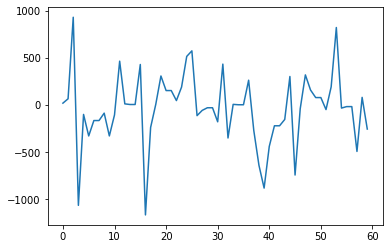

In [61]:
# 看走勢
tmpD = Data_new['delta']
print(tmpD.plot())

# 做scaler
tmpD = tmpD.to_numpy().reshape(-1, 1)
scalerD = MinMaxScaler()
tempD = scalerD.fit_transform(tmpD)
print("shape:", tempD.shape)

-> 結果很差ㄡ...

### Part 2: 提供過去3天的DJIA + GPOMS 資料: 

multi-variable

> X[0]: [[ [1-1, 1-2, ..], [2-1, 2-2, ...], [3-1, 3-2, ...]]]

> y[0]: [4]


In [194]:
Data.head(3)

,Dates,Close,Calm,Kind,Happy,Alert,Sure,Vital
0,2022-05-01,33040.427734,0.113750,0.132750,-0.002000,0.421500,0.104200,-0.211500
1,2022-05-02,33061.500000,0.036875,0.169769,-0.098667,0.329500,0.102600,-0.021833
2,2022-05-03,33128.789062,0.020400,0.093375,-0.163818,0.557714,0.141286,0.215077


In [193]:
temp2 = Data.set_index('Dates')
mms_close = MinMaxScaler()
mms_calm = MinMaxScaler()
mms_kind = MinMaxScaler()
mms_happy = MinMaxScaler()
mms_alert = MinMaxScaler()
mms_sure = MinMaxScaler()
mms_vital = MinMaxScaler()
mms_delta = MinMaxScaler()

temp2['Close'] = mms_close.fit_transform(np.array(temp2['Close']).reshape(-1, 1))
temp2['Calm'] = mms_calm.fit_transform(np.array(temp2['Calm']).reshape(-1, 1))
temp2['Kind'] = mms_kind.fit_transform(np.array(temp2['Kind']).reshape(-1, 1))
temp2['Happy'] = mms_happy.fit_transform(np.array(temp2['Happy']).reshape(-1, 1))
temp2['Alert'] = mms_alert.fit_transform(np.array(temp2['Alert']).reshape(-1, 1))
temp2['Sure'] = mms_sure.fit_transform(np.array(temp2['Sure']).reshape(-1, 1))
temp2['Vital'] = mms_vital.fit_transform(np.array(temp2['Vital']).reshape(-1, 1))

temp2.head()

,Close,Calm,Kind,Happy,Alert,Sure,Vital
Dates,,,,,,,
2022-05-01,0.755378,0.396493,0.581722,0.600000,0.421500,0.415091,0.121821
2022-05-02,0.760429,0.344144,0.627909,0.532636,0.329500,0.411264,0.346146
2022-05-03,0.776556,0.332925,0.532595,0.487235,0.557714,0.503800,0.626348
2022-05-04,1.000000,0.450119,0.626069,0.485668,0.447250,0.409231,0.585781
2022-05-05,0.745202,0.191488,0.588688,0.490128,0.312538,0.580558,0.537767


In [195]:
def df_to_X_y2(df, window_size=3):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [196]:
WINDOW_SIZE = 3
NUM_FEATURE = 7

X2, y2 = df_to_X_y2(temp2, WINDOW_SIZE)
X2.shape, y2.shape # number of data, # size of window, number of features

((58, 3, 7), (58,))

In [197]:
threshold = 41
X_train2, y_train2 = X2[:threshold-3], y2[:threshold-3]
X_test2, y_test2 = X2[threshold:], y2[threshold:]
X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape

((38, 3, 7), (38,), (17, 3, 7), (17,))

In [198]:
model2 = Sequential()
model2.add(InputLayer((WINDOW_SIZE, NUM_FEATURE)))
model2.add(LSTM(64))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 64)                18432     
                                                                 
 dense_28 (Dense)            (None, 8)                 520       
                                                                 
 dense_29 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,961
Trainable params: 18,961
Non-trainable params: 0
_________________________________________________________________


In [199]:
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])
model2.fit(X_train2, y_train2, epochs=10)

Epoch 1/10
2/2 [==============================] - 2s 5ms/step - loss: 0.3743 - root_mean_squared_error: 0.6118
Epoch 2/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0327 - root_mean_squared_error: 0.1810
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0541 - root_mean_squared_error: 0.2327
Epoch 4/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0297 - root_mean_squared_error: 0.1725
Epoch 5/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0468 - root_mean_squared_error: 0.2162
Epoch 6/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0266 - root_mean_squared_error: 0.1631
Epoch 7/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0212 - root_mean_squared_error: 0.1456
Epoch 8/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0307 - root_mean_squared_error: 0.1754
Epoch 9/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0219 - root_mean_squared_error: 0.1481
E

2/2 [==============================] - 0s 2ms/step


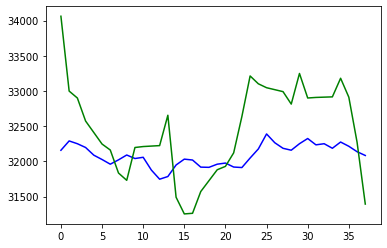

In [200]:
# train result
train_predictions2 = model2.predict(X_train2).flatten()
pred = mms_close.inverse_transform(train_predictions2.reshape(-1, 1))
pred = pred.reshape(-1,)
act = mms_close.inverse_transform(y_train2.reshape(-1, 1))
act = act.reshape(-1,)

train_results2 = pd.DataFrame(data={
    'Train Predictions':pred, 
    'Actuals':act})

plt.plot(train_results2['Train Predictions'], c='b')
plt.plot(train_results2['Actuals'], c='g')

1/1 [==============================] - 0s 26ms/step


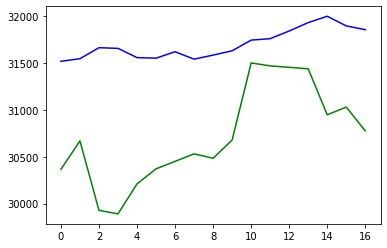

In [201]:
# Test result
test_predictions2 = model2.predict(X_test2).flatten()
pred = mms_close.inverse_transform(test_predictions2.reshape(-1, 1))
pred = pred.reshape(-1,)
act = mms_close.inverse_transform(y_test2.reshape(-1, 1))
act = act.reshape(-1,)

test_results2 = pd.DataFrame(data={
    'Test Predictions':pred, 
    'Actuals':act})

plt.plot(test_results2['Test Predictions'], c='b')
plt.plot(test_results2['Actuals'], c='g')

# IV. Compute MAPE & Direction correct rate

In [164]:
def mape(actual, predict): 
    actual, predict = np.array(actual), np.array(predict)
    return np.mean(np.abs((actual - predict) / actual)) * 100

def direction(actual, predict): 
    prev_act = actual[0]
    prev_pred = predict[0]
    true = []
    res = []
    for i, j in zip(actual[1:], predict[1:]): 
        if i>=prev_act:
            true.append(1)
        else:
            true.append(-1)
        if j>=prev_pred:
            res.append(1)
        else:
            res.append(-1)
        prev_act = i
        prev_pred = j
    denorminator = len(actual) -1
    numerator = 0
    for i, j in zip(true, res):
        if i==j:
            numerator += 1
    return (numerator / denorminator)

In [202]:
# Part 1: past three days' DJIA data
print("MAPE:", mape(test_results1['Actuals'], test_results1['Test Predictions']).round(3), "%")
print("Directional correction rate:", "{0:.0%}".format(direction(test_results1['Actuals'], test_results1['Test Predictions'])) )

MAPE: 3.455 %
Directional correction rate: 50%


In [203]:
test_results1

,Test Predictions,Actuals
0,31803.748047,30364.830078
1,31682.876953,30668.529297
2,31663.128906,29927.070312
3,31557.136719,29888.779297
4,31450.230469,30209.514648
5,31351.392578,30369.882324
6,31444.332031,30450.066162
7,31560.064453,30530.250000
8,31625.482422,30483.130859
9,31650.279297,30677.359375


In [204]:
fig = px.line(test_results1)
fig.show()

In [205]:
test_results2

,Test Predictions,Actuals
0,31518.238281,30364.830078
1,31546.105469,30668.529297
2,31663.634766,29927.070312
3,31656.390625,29888.779297
4,31557.861328,30209.514648
5,31551.763672,30369.882324
6,31620.390625,30450.066162
7,31541.347656,30530.250000
8,31584.572266,30483.130859
9,31630.464844,30677.359375


In [206]:
# Part 2: past three days' DJIA data + GPOMS
print("MAPE: ", mape(test_results2['Actuals'], test_results2['Test Predictions']).round(3), "%")
print("Directional correction rate:", "{0:.0%}".format(direction(test_results2['Actuals'], test_results2['Test Predictions'])) )

MAPE:  3.224 %
Directional correction rate: 38%


In [207]:
fig = px.line(test_results2)
fig.show()

reference: 

https://colab.research.google.com/drive/1b3CUJuDOmPmNdZFH3LQDmt5F0K3FZhqD?usp=sharing#scrollTo=FmwshpETs-jE


# PART2

In [237]:
type = Data.columns[2:]
type

Index(['Calm', 'Kind', 'Happy', 'Alert', 'Sure', 'Vital'], dtype='object')

In [238]:
for t in type:
    print(t,":", sum(Data[t].abs()))

Calm : 9.316614483698348
Kind : 8.852421440424672
Happy : 8.090488849840316
Alert : 26.540816478926743
Sure : 6.893989295370392
Vital : 9.655290019463067


In [253]:
for i in type:
    tmp = temp2[['Close', i]]

    WINDOW_SIZE = 3
    NUM_FEATURE = 2
    threshold = 41

    X2, y2 = df_to_X_y2(tmp, WINDOW_SIZE)
    X2.shape, y2.shape # number of data, # size of window, number of features

    X_train2, y_train2 = X2[:threshold-3], y2[:threshold-3]
    X_test2, y_test2 = X2[threshold:], y2[threshold:]
    X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape

    model2 = Sequential()
    model2.add(InputLayer((WINDOW_SIZE, NUM_FEATURE)))
    model2.add(LSTM(64))
    model2.add(Dense(8, 'relu'))
    model2.add(Dense(1, 'linear'))
    model2.summary()

    model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])
    model2.fit(X_train2, y_train2, epochs=10)

    # train result
    train_predictions2 = model2.predict(X_train2).flatten()
    pred = mms_close.inverse_transform(train_predictions2.reshape(-1, 1))
    pred = pred.reshape(-1,)
    act = mms_close.inverse_transform(y_train2.reshape(-1, 1))
    act = act.reshape(-1,)

    train_results2 = pd.DataFrame(data={
        'Train Predictions':pred, 
        'Actuals':act})

#     plt.plot(train_results2['Train Predictions'], c='b')
#     plt.plot(train_results2['Actuals'], c='g')

    # Test result
    test_predictions2 = model2.predict(X_test2).flatten()
    pred = mms_close.inverse_transform(test_predictions2.reshape(-1, 1))
    pred = pred.reshape(-1,)
    act = mms_close.inverse_transform(y_test2.reshape(-1, 1))
    act = act.reshape(-1,)

    test_results2 = pd.DataFrame(data={
        'Test Predictions':pred, 
        'Actuals':act})
    
#     plt.plot(test_results2['Test Predictions'], c='b')
#     plt.plot(test_results2['Actuals'], c='g')
    
    print("-----", i, "-----")
    print("MAPE: ", mape(test_results2['Actuals'], test_results2['Test Predictions']).round(3), "%")
    print("Directional correction rate:", "{0:.0%}".format(direction(test_results2['Actuals'], test_results2['Test Predictions'])) )

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 64)                17152     
                                                                 
 dense_78 (Dense)            (None, 8)                 520       
                                                                 
 dense_79 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,681
Trainable params: 17,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 2s 4ms/step - loss: 0.3409 - root_mean_squared_error: 0.5839
Epoch 2/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0628 - root_mean_squared_error: 0.2506
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0716 - root_mean_sq

1/1 [==============================] - 0s 13ms/step
----- Alert -----
MAPE:  4.346 %
Directional correction rate: 19%
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_43 (LSTM)              (None, 64)                17152     
                                                                 
 dense_86 (Dense)            (None, 8)                 520       
                                                                 
 dense_87 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,681
Trainable params: 17,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 1s 4ms/step - loss: 0.3315 - root_mean_squared_error: 0.5758
Epoch 2/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0353 - root_

In [290]:
import itertools
sum = list(itertools.combinations(type, 2))
print(sum)

print("----------")
for i in sum:
    i = list(i)+['Close']
    print(i)

[('Calm', 'Kind'), ('Calm', 'Happy'), ('Calm', 'Alert'), ('Calm', 'Sure'), ('Calm', 'Vital'), ('Kind', 'Happy'), ('Kind', 'Alert'), ('Kind', 'Sure'), ('Kind', 'Vital'), ('Happy', 'Alert'), ('Happy', 'Sure'), ('Happy', 'Vital'), ('Alert', 'Sure'), ('Alert', 'Vital'), ('Sure', 'Vital')]
----------
['Calm', 'Kind', 'Close']
['Calm', 'Happy', 'Close']
['Calm', 'Alert', 'Close']
['Calm', 'Sure', 'Close']
['Calm', 'Vital', 'Close']
['Kind', 'Happy', 'Close']
['Kind', 'Alert', 'Close']
['Kind', 'Sure', 'Close']
['Kind', 'Vital', 'Close']
['Happy', 'Alert', 'Close']
['Happy', 'Sure', 'Close']
['Happy', 'Vital', 'Close']
['Alert', 'Sure', 'Close']
['Alert', 'Vital', 'Close']
['Sure', 'Vital', 'Close']


In [295]:
for i in range(2, 7, 1):
    sum = list(itertools.combinations(type, i))
    print(sum)

[('Calm', 'Kind'), ('Calm', 'Happy'), ('Calm', 'Alert'), ('Calm', 'Sure'), ('Calm', 'Vital'), ('Kind', 'Happy'), ('Kind', 'Alert'), ('Kind', 'Sure'), ('Kind', 'Vital'), ('Happy', 'Alert'), ('Happy', 'Sure'), ('Happy', 'Vital'), ('Alert', 'Sure'), ('Alert', 'Vital'), ('Sure', 'Vital')]
[('Calm', 'Kind', 'Happy'), ('Calm', 'Kind', 'Alert'), ('Calm', 'Kind', 'Sure'), ('Calm', 'Kind', 'Vital'), ('Calm', 'Happy', 'Alert'), ('Calm', 'Happy', 'Sure'), ('Calm', 'Happy', 'Vital'), ('Calm', 'Alert', 'Sure'), ('Calm', 'Alert', 'Vital'), ('Calm', 'Sure', 'Vital'), ('Kind', 'Happy', 'Alert'), ('Kind', 'Happy', 'Sure'), ('Kind', 'Happy', 'Vital'), ('Kind', 'Alert', 'Sure'), ('Kind', 'Alert', 'Vital'), ('Kind', 'Sure', 'Vital'), ('Happy', 'Alert', 'Sure'), ('Happy', 'Alert', 'Vital'), ('Happy', 'Sure', 'Vital'), ('Alert', 'Sure', 'Vital')]
[('Calm', 'Kind', 'Happy', 'Alert'), ('Calm', 'Kind', 'Happy', 'Sure'), ('Calm', 'Kind', 'Happy', 'Vital'), ('Calm', 'Kind', 'Alert', 'Sure'), ('Calm', 'Kind', 'Al

In [278]:
for i in sum:
    i = list(i)+['Close']
    tmp = temp2[i]

    WINDOW_SIZE = 3
    NUM_FEATURE = 3
    threshold = 41

    X2, y2 = df_to_X_y2(tmp, WINDOW_SIZE)
    X2.shape, y2.shape # number of data, # size of window, number of features

    X_train2, y_train2 = X2[:threshold-3], y2[:threshold-3]
    X_test2, y_test2 = X2[threshold:], y2[threshold:]
    X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape

    model2 = Sequential()
    model2.add(InputLayer((WINDOW_SIZE, NUM_FEATURE)))
    model2.add(LSTM(64))
    model2.add(Dense(8, 'relu'))
    model2.add(Dense(1, 'linear'))
    model2.summary()

    model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])
    model2.fit(X_train2, y_train2, epochs=10)

    # train result
    train_predictions2 = model2.predict(X_train2).flatten()
    pred = mms_close.inverse_transform(train_predictions2.reshape(-1, 1))
    pred = pred.reshape(-1,)
    act = mms_close.inverse_transform(y_train2.reshape(-1, 1))
    act = act.reshape(-1,)

    train_results2 = pd.DataFrame(data={
        'Train Predictions':pred, 
        'Actuals':act})

#     plt.plot(train_results2['Train Predictions'], c='b')
#     plt.plot(train_results2['Actuals'], c='g')

    # Test result
    test_predictions2 = model2.predict(X_test2).flatten()
    pred = mms_close.inverse_transform(test_predictions2.reshape(-1, 1))
    pred = pred.reshape(-1,)
    act = mms_close.inverse_transform(y_test2.reshape(-1, 1))
    act = act.reshape(-1,)

    test_results2 = pd.DataFrame(data={
        'Test Predictions':pred, 
        'Actuals':act})
    
#     plt.plot(test_results2['Test Predictions'], c='b')
#     plt.plot(test_results2['Actuals'], c='g')
    
    print("-----", i, "-----")
    print("MAPE: ", mape(test_results2['Actuals'], test_results2['Test Predictions']).round(3), "%")
    print("Directional correction rate:", "{0:.0%}".format(direction(test_results2['Actuals'], test_results2['Test Predictions'])) )

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 64)                17408     
                                                                 
 dense_90 (Dense)            (None, 8)                 520       
                                                                 
 dense_91 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,937
Trainable params: 17,937
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 2s 4ms/step - loss: 0.1266 - root_mean_squared_error: 0.3558
Epoch 2/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0388 - root_mean_squared_error: 0.1970
Epoch 3/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0570 - root_mean_sq

1/1 [==============================] - 0s 16ms/step
----- ['Calm', 'Sure', 'Close'] -----
MAPE:  1.891 %
Directional correction rate: 44%
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)              (None, 64)                17408     
                                                                 
 dense_98 (Dense)            (None, 8)                 520       
                                                                 
 dense_99 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,937
Trainable params: 17,937
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 2s 5ms/step - loss: 0.0801 - root_mean_squared_error: 0.2830
Epoch 2/10
2/2 [==============================] - 0s 4ms/step - 

2/2 [==============================] - 0s 5ms/step - loss: 0.0396 - root_mean_squared_error: 0.1990
Epoch 8/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0360 - root_mean_squared_error: 0.1898
Epoch 9/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0394 - root_mean_squared_error: 0.1984
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
----- ['Kind', 'Sure', 'Close'] -----
MAPE:  1.907 %
Directional correction rate: 38%
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_53 (LSTM)              (None, 64)                17408     
                                                                 
 dense_106 (Dense)           (None, 8)                 520       
                                                                 
 dense_107 (Dense)           (None, 1)                 9         
                                           

2/2 [==============================] - 0s 6ms/step - loss: 0.0573 - root_mean_squared_error: 0.2393
Epoch 5/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0250 - root_mean_squared_error: 0.1580
Epoch 6/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0315 - root_mean_squared_error: 0.1773
Epoch 7/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0271 - root_mean_squared_error: 0.1645
Epoch 8/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0229 - root_mean_squared_error: 0.1515
Epoch 9/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0294 - root_mean_squared_error: 0.1714
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
----- ['Happy', 'Vital', 'Close'] -----
MAPE:  0.937 %
Directional correction rate: 31%
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_57 (LSTM)              (None, 64

In [287]:
NUM_FEATURE = 4
sum = list(itertools.combinations(type, NUM_FEATURE-1))

for i in sum:
    i = list(i)+['Close']
    tmp = temp2[i]

    WINDOW_SIZE = 3
    threshold = 41

    X2, y2 = df_to_X_y2(tmp, WINDOW_SIZE)
    X2.shape, y2.shape # number of data, # size of window, number of features

    X_train2, y_train2 = X2[:threshold-3], y2[:threshold-3]
    X_test2, y_test2 = X2[threshold:], y2[threshold:]
    X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape

    model2 = Sequential()
    model2.add(InputLayer((WINDOW_SIZE, NUM_FEATURE)))
    model2.add(LSTM(64))
    model2.add(Dense(8, 'relu'))
    model2.add(Dense(1, 'linear'))
    model2.summary()

    model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])
    model2.fit(X_train2, y_train2, epochs=10)

    # train result
    train_predictions2 = model2.predict(X_train2).flatten()
    pred = mms_close.inverse_transform(train_predictions2.reshape(-1, 1))
    pred = pred.reshape(-1,)
    act = mms_close.inverse_transform(y_train2.reshape(-1, 1))
    act = act.reshape(-1,)

    train_results2 = pd.DataFrame(data={
        'Train Predictions':pred, 
        'Actuals':act})

#     plt.plot(train_results2['Train Predictions'], c='b')
#     plt.plot(train_results2['Actuals'], c='g')

    # Test result
    test_predictions2 = model2.predict(X_test2).flatten()
    pred = mms_close.inverse_transform(test_predictions2.reshape(-1, 1))
    pred = pred.reshape(-1,)
    act = mms_close.inverse_transform(y_test2.reshape(-1, 1))
    act = act.reshape(-1,)

    test_results2 = pd.DataFrame(data={
        'Test Predictions':pred, 
        'Actuals':act})
    
#     plt.plot(test_results2['Test Predictions'], c='b')
#     plt.plot(test_results2['Actuals'], c='g')
    
    print("-----", i, "-----")
    print("MAPE: ", mape(test_results2['Actuals'], test_results2['Test Predictions']).round(3), "%")
    print("Directional correction rate:", "{0:.0%}".format(direction(test_results2['Actuals'], test_results2['Test Predictions'])) )

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_61 (LSTM)              (None, 64)                17664     
                                                                 
 dense_122 (Dense)           (None, 8)                 520       
                                                                 
 dense_123 (Dense)           (None, 1)                 9         
                                                                 
Total params: 18,193
Trainable params: 18,193
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 2s 5ms/step - loss: 0.1104 - root_mean_squared_error: 0.3323
Epoch 2/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0738 - root_mean_squared_error: 0.2716
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0312 - root_mean_sq

2/2 [==============================] - 0s 4ms/step - loss: 0.0260 - root_mean_squared_error: 0.1611
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
----- ['Calm', 'Kind', 'Vital', 'Close'] -----
MAPE:  1.006 %
Directional correction rate: 44%
Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_65 (LSTM)              (None, 64)                17664     
                                                                 
 dense_130 (Dense)           (None, 8)                 520       
                                                                 
 dense_131 (Dense)           (None, 1)                 9         
                                                                 
Total params: 18,193
Trainable params: 18,193
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 1s 5

2/2 [==============================] - 0s 3ms/step - loss: 0.0446 - root_mean_squared_error: 0.2113
Epoch 7/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0499 - root_mean_squared_error: 0.2234
Epoch 8/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0433 - root_mean_squared_error: 0.2081
Epoch 9/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0336 - root_mean_squared_error: 0.1834
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
----- ['Calm', 'Alert', 'Sure', 'Close'] -----
MAPE:  1.04 %
Directional correction rate: 44%
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_69 (LSTM)              (None, 64)                17664     
                                                                 
 dense_138 (Dense)           (None, 8)                 520       
                                                        

2/2 [==============================] - 0s 4ms/step - loss: 0.0868 - root_mean_squared_error: 0.2946
Epoch 4/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0378 - root_mean_squared_error: 0.1945
Epoch 5/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0663 - root_mean_squared_error: 0.2574
Epoch 6/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0661 - root_mean_squared_error: 0.2572
Epoch 7/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0461 - root_mean_squared_error: 0.2146
Epoch 8/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0343 - root_mean_squared_error: 0.1853
Epoch 9/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0405 - root_mean_squared_error: 0.2012
Epoch 10/10
1/1 [==============================] - 0s 12ms/step
----- ['Kind', 'Happy', 'Sure', 'Close'] -----
MAPE:  1.252 %
Directional correction rate: 44%
Model: "sequential_73"
____________________________________________________

_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 2s 4ms/step - loss: 0.4013 - root_mean_squared_error: 0.6335
Epoch 2/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0745 - root_mean_squared_error: 0.2730
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0728 - root_mean_squared_error: 0.2698
Epoch 4/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0419 - root_mean_squared_error: 0.2046
Epoch 5/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0355 - root_mean_squared_error: 0.1883
Epoch 6/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0397 - root_mean_squared_error: 0.1993
Epoch 7/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0432 - root_mean_squared_error: 0.2079
Epoch 8/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0391 - root_mean_squared_error: 0.1976
Epoch 9/10
2/2 [==============================

 dense_161 (Dense)           (None, 1)                 9         
                                                                 
Total params: 18,193
Trainable params: 18,193
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 1s 5ms/step - loss: 0.2534 - root_mean_squared_error: 0.5033
Epoch 2/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0495 - root_mean_squared_error: 0.2224
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0357 - root_mean_squared_error: 0.1889
Epoch 4/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0171 - root_mean_squared_error: 0.1306
Epoch 5/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0321 - root_mean_squared_error: 0.1792
Epoch 6/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0168 - root_mean_squared_error: 0.1294
Epoch 7/10
2/2 [==============================] - 0s 5ms/step - lo

In [289]:
num = [5, 6, 7]

for j in num:
    NUM_FEATURE = j
    sum = list(itertools.combinations(type, NUM_FEATURE-1))

    for i in sum:
        i = list(i)+['Close']
        tmp = temp2[i]

        WINDOW_SIZE = 3
        threshold = 41

        X2, y2 = df_to_X_y2(tmp, WINDOW_SIZE)
        X2.shape, y2.shape # number of data, # size of window, number of features

        X_train2, y_train2 = X2[:threshold-3], y2[:threshold-3]
        X_test2, y_test2 = X2[threshold:], y2[threshold:]
        X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape

        model2 = Sequential()
        model2.add(InputLayer((WINDOW_SIZE, NUM_FEATURE)))
        model2.add(LSTM(64))
        model2.add(Dense(8, 'relu'))
        model2.add(Dense(1, 'linear'))
        model2.summary()

        model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])
        model2.fit(X_train2, y_train2, epochs=10)

        # train result
        train_predictions2 = model2.predict(X_train2).flatten()
        pred = mms_close.inverse_transform(train_predictions2.reshape(-1, 1))
        pred = pred.reshape(-1,)
        act = mms_close.inverse_transform(y_train2.reshape(-1, 1))
        act = act.reshape(-1,)

        train_results2 = pd.DataFrame(data={
            'Train Predictions':pred, 
            'Actuals':act})

    #     plt.plot(train_results2['Train Predictions'], c='b')
    #     plt.plot(train_results2['Actuals'], c='g')

        # Test result
        test_predictions2 = model2.predict(X_test2).flatten()
        pred = mms_close.inverse_transform(test_predictions2.reshape(-1, 1))
        pred = pred.reshape(-1,)
        act = mms_close.inverse_transform(y_test2.reshape(-1, 1))
        act = act.reshape(-1,)

        test_results2 = pd.DataFrame(data={
            'Test Predictions':pred, 
            'Actuals':act})

    #     plt.plot(test_results2['Test Predictions'], c='b')
    #     plt.plot(test_results2['Actuals'], c='g')

        print("-----", i, "-----")
        print("MAPE: ", mape(test_results2['Actuals'], test_results2['Test Predictions']).round(3), "%")
        print("Directional correction rate:", "{0:.0%}".format(direction(test_results2['Actuals'], test_results2['Test Predictions'])) )

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_81 (LSTM)              (None, 64)                17920     
                                                                 
 dense_162 (Dense)           (None, 8)                 520       
                                                                 
 dense_163 (Dense)           (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 1s 4ms/step - loss: 0.1866 - root_mean_squared_error: 0.4320
Epoch 2/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0645 - root_mean_squared_error: 0.2540
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0422 - root_mean_sq

2/2 [==============================] - 0s 5ms/step - loss: 0.0362 - root_mean_squared_error: 0.1902
Epoch 10/10
1/1 [==============================] - 0s 19ms/step
----- ['Calm', 'Kind', 'Alert', 'Sure', 'Close'] -----
MAPE:  1.056 %
Directional correction rate: 44%
Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_85 (LSTM)              (None, 64)                17920     
                                                                 
 dense_170 (Dense)           (None, 8)                 520       
                                                                 
 dense_171 (Dense)           (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================

2/2 [==============================] - 0s 5ms/step - loss: 0.0372 - root_mean_squared_error: 0.1928
Epoch 6/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0426 - root_mean_squared_error: 0.2064
Epoch 7/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0332 - root_mean_squared_error: 0.1823
Epoch 8/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0253 - root_mean_squared_error: 0.1590
Epoch 9/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0250 - root_mean_squared_error: 0.1582
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
----- ['Calm', 'Happy', 'Alert', 'Vital', 'Close'] -----
MAPE:  0.876 %
Directional correction rate: 31%
Model: "sequential_89"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_89 (LSTM)              (None, 64)                17920     
                                                                 


2/2 [==============================] - 1s 4ms/step - loss: 0.2793 - root_mean_squared_error: 0.5285
Epoch 2/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0647 - root_mean_squared_error: 0.2543
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0634 - root_mean_squared_error: 0.2518
Epoch 4/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0575 - root_mean_squared_error: 0.2399
Epoch 5/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0454 - root_mean_squared_error: 0.2131
Epoch 6/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0480 - root_mean_squared_error: 0.2190
Epoch 7/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0447 - root_mean_squared_error: 0.2115
Epoch 8/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0370 - root_mean_squared_error: 0.1923
Epoch 9/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0475 - root_mean_squared_error: 0.2180
Epoch 10/10


 dense_193 (Dense)           (None, 1)                 9         
                                                                 
Total params: 18,705
Trainable params: 18,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 1s 5ms/step - loss: 0.2437 - root_mean_squared_error: 0.4937
Epoch 2/10
2/2 [==============================] - 0s 4ms/step - loss: 0.1511 - root_mean_squared_error: 0.3887
Epoch 3/10
2/2 [==============================] - 0s 6ms/step - loss: 0.1247 - root_mean_squared_error: 0.3532
Epoch 4/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0887 - root_mean_squared_error: 0.2978
Epoch 5/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0301 - root_mean_squared_error: 0.1734
Epoch 6/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0474 - root_mean_squared_error: 0.2176
Epoch 7/10
2/2 [==============================] - 0s 4ms/step - lo

 lstm_100 (LSTM)             (None, 64)                18176     
                                                                 
 dense_200 (Dense)           (None, 8)                 520       
                                                                 
 dense_201 (Dense)           (None, 1)                 9         
                                                                 
Total params: 18,705
Trainable params: 18,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 2s 5ms/step - loss: 0.0960 - root_mean_squared_error: 0.3098
Epoch 2/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0403 - root_mean_squared_error: 0.2008
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0305 - root_mean_squared_error: 0.1747
Epoch 4/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0239 - root_mean_squared_error: 0.1548
Epoch 5/10
2/2 [========

In [300]:
def eval(results):
    MAPE = mape(results['Actuals'], results['Test Predictions']).round(3)
    Direction =  "{0:.0%}".format(direction(results['Actuals'], results['Test Predictions']))
    return MAPE, Direction

In [311]:
finish = []

num = [2, 3, 4, 5, 6, 7]
for j in num:
    NUM_FEATURE = j
    sum = list(itertools.combinations(type, NUM_FEATURE-1))

    for i in sum:
        i = list(i)+['Close']
        tmp = temp2[i]

        WINDOW_SIZE = 3
        threshold = 41

        X2, y2 = df_to_X_y2(tmp, WINDOW_SIZE)
        X2.shape, y2.shape # number of data, # size of window, number of features

        X_train2, y_train2 = X2[:threshold-3], y2[:threshold-3]
        X_test2, y_test2 = X2[threshold:], y2[threshold:]
        X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape

        model2 = Sequential()
        model2.add(InputLayer((WINDOW_SIZE, NUM_FEATURE)))
        model2.add(LSTM(64))
        model2.add(Dense(8, 'relu'))
        model2.add(Dense(1, 'linear'))
        model2.summary()

        model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])
        model2.fit(X_train2, y_train2, epochs=10)

        # train result
        train_predictions2 = model2.predict(X_train2).flatten()
        pred = mms_close.inverse_transform(train_predictions2.reshape(-1, 1))
        pred = pred.reshape(-1,)
        act = mms_close.inverse_transform(y_train2.reshape(-1, 1))
        act = act.reshape(-1,)

        train_results2 = pd.DataFrame(data={
            'Train Predictions':pred, 
            'Actuals':act})

        # Test result
        test_predictions2 = model2.predict(X_test2).flatten()
        pred = mms_close.inverse_transform(test_predictions2.reshape(-1, 1))
        pred = pred.reshape(-1,)
        act = mms_close.inverse_transform(y_test2.reshape(-1, 1))
        act = act.reshape(-1,)

        test_results2 = pd.DataFrame(data={
            'Test Predictions':pred, 
            'Actuals':act})
        
        e1, e2 = eval(test_results2)
        finish.append([i, e1,e2])
        

Model: "sequential_119"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_119 (LSTM)             (None, 64)                17152     
                                                                 
 dense_238 (Dense)           (None, 8)                 520       
                                                                 
 dense_239 (Dense)           (None, 1)                 9         
                                                                 
Total params: 17,681
Trainable params: 17,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 1s 5ms/step - loss: 0.1221 - root_mean_squared_error: 0.3495
Epoch 2/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0359 - root_mean_squared_error: 0.1894
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0637 - root_mean_s

 Layer (type)                Output Shape              Param #   
 lstm_123 (LSTM)             (None, 64)                17152     
                                                                 
 dense_246 (Dense)           (None, 8)                 520       
                                                                 
 dense_247 (Dense)           (None, 1)                 9         
                                                                 
Total params: 17,681
Trainable params: 17,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 1s 4ms/step - loss: 0.2082 - root_mean_squared_error: 0.4563
Epoch 2/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0543 - root_mean_squared_error: 0.2330
Epoch 3/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0624 - root_mean_squared_error: 0.2498
Epoch 4/10
2/2 [==============================] - 0s 5ms/step - loss:

 lstm_127 (LSTM)             (None, 64)                17408     
                                                                 
 dense_254 (Dense)           (None, 8)                 520       
                                                                 
 dense_255 (Dense)           (None, 1)                 9         
                                                                 
Total params: 17,937
Trainable params: 17,937
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 1s 4ms/step - loss: 0.0937 - root_mean_squared_error: 0.3061
Epoch 2/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0578 - root_mean_squared_error: 0.2404
Epoch 3/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0293 - root_mean_squared_error: 0.1713
Epoch 4/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0341 - root_mean_squared_error: 0.1845
Epoch 5/10
2/2 [========

 lstm_131 (LSTM)             (None, 64)                17408     
                                                                 
 dense_262 (Dense)           (None, 8)                 520       
                                                                 
 dense_263 (Dense)           (None, 1)                 9         
                                                                 
Total params: 17,937
Trainable params: 17,937
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 1s 4ms/step - loss: 0.3046 - root_mean_squared_error: 0.5519
Epoch 2/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0500 - root_mean_squared_error: 0.2236
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 0.1217 - root_mean_squared_error: 0.3488
Epoch 4/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0370 - root_mean_squared_error: 0.1924
Epoch 5/10
2/2 [========

                                                                 
 dense_270 (Dense)           (None, 8)                 520       
                                                                 
 dense_271 (Dense)           (None, 1)                 9         
                                                                 
Total params: 17,937
Trainable params: 17,937
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 2s 4ms/step - loss: 0.3152 - root_mean_squared_error: 0.5615
Epoch 2/10
2/2 [==============================] - 0s 4ms/step - loss: 0.2005 - root_mean_squared_error: 0.4478
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0838 - root_mean_squared_error: 0.2895
Epoch 4/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0250 - root_mean_squared_error: 0.1580
Epoch 5/10
2/2 [==============================] - 0s 4ms/step - loss: 0.1069 - root_mean_s

 dense_278 (Dense)           (None, 8)                 520       
                                                                 
 dense_279 (Dense)           (None, 1)                 9         
                                                                 
Total params: 17,937
Trainable params: 17,937
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 1s 4ms/step - loss: 0.2827 - root_mean_squared_error: 0.5317
Epoch 2/10
2/2 [==============================] - 0s 5ms/step - loss: 0.2058 - root_mean_squared_error: 0.4536
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0859 - root_mean_squared_error: 0.2932
Epoch 4/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0687 - root_mean_squared_error: 0.2621
Epoch 5/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0995 - root_mean_squared_error: 0.3155
Epoch 6/10
2/2 [=============================

                                                                 
 dense_287 (Dense)           (None, 1)                 9         
                                                                 
Total params: 18,193
Trainable params: 18,193
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 1s 6ms/step - loss: 0.1356 - root_mean_squared_error: 0.3683
Epoch 2/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0483 - root_mean_squared_error: 0.2197
Epoch 3/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0276 - root_mean_squared_error: 0.1660
Epoch 4/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0296 - root_mean_squared_error: 0.1719
Epoch 5/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0425 - root_mean_squared_error: 0.2061
Epoch 6/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0324 - root_mean_squared_error: 0.1799


 dense_295 (Dense)           (None, 1)                 9         
                                                                 
Total params: 18,193
Trainable params: 18,193
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 1s 4ms/step - loss: 0.1951 - root_mean_squared_error: 0.4417
Epoch 2/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0471 - root_mean_squared_error: 0.2169
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0440 - root_mean_squared_error: 0.2099
Epoch 4/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0373 - root_mean_squared_error: 0.1932
Epoch 5/10
2/2 [==============================] - 0s 3ms/step - loss: 0.0418 - root_mean_squared_error: 0.2043
Epoch 6/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0307 - root_mean_squared_error: 0.1751
Epoch 7/10
2/2 [==============================] - 0s 4ms/step - lo

                                                                 
Total params: 18,193
Trainable params: 18,193
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 1s 4ms/step - loss: 0.2637 - root_mean_squared_error: 0.5135
Epoch 2/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0640 - root_mean_squared_error: 0.2530
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0659 - root_mean_squared_error: 0.2568
Epoch 4/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0382 - root_mean_squared_error: 0.1955
Epoch 5/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0370 - root_mean_squared_error: 0.1924
Epoch 6/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0370 - root_mean_squared_error: 0.1924
Epoch 7/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0381 - root_mean_squared_error: 0.1951
Epoch 8/10
2/2 [=====

Total params: 18,193
Trainable params: 18,193
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 2s 4ms/step - loss: 0.1236 - root_mean_squared_error: 0.3516
Epoch 2/10
2/2 [==============================] - 0s 4ms/step - loss: 0.1924 - root_mean_squared_error: 0.4386
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0407 - root_mean_squared_error: 0.2018
Epoch 4/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0838 - root_mean_squared_error: 0.2895
Epoch 5/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0689 - root_mean_squared_error: 0.2625
Epoch 6/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0371 - root_mean_squared_error: 0.1927
Epoch 7/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0442 - root_mean_squared_error: 0.2101
Epoch 8/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0516 - root_mea

Total params: 18,193
Trainable params: 18,193
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 1s 4ms/step - loss: 0.1147 - root_mean_squared_error: 0.3387
Epoch 2/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0449 - root_mean_squared_error: 0.2118
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0220 - root_mean_squared_error: 0.1485
Epoch 4/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0288 - root_mean_squared_error: 0.1698
Epoch 5/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0274 - root_mean_squared_error: 0.1656
Epoch 6/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0183 - root_mean_squared_error: 0.1352
Epoch 7/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0189 - root_mean_squared_error: 0.1375
Epoch 8/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0202 - root_mea

_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 1s 4ms/step - loss: 0.0910 - root_mean_squared_error: 0.3017
Epoch 2/10
2/2 [==============================] - 0s 5ms/step - loss: 0.1440 - root_mean_squared_error: 0.3795
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0262 - root_mean_squared_error: 0.1617
Epoch 4/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0692 - root_mean_squared_error: 0.2630
Epoch 5/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0427 - root_mean_squared_error: 0.2066
Epoch 6/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0302 - root_mean_squared_error: 0.1738
Epoch 7/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0246 - root_mean_squared_error: 0.1569
Epoch 8/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0289 - root_mean_squared_error: 0.1701
Epoch 9/10
2/2 [==============================

Epoch 1/10
2/2 [==============================] - 1s 4ms/step - loss: 0.1700 - root_mean_squared_error: 0.4124
Epoch 2/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0413 - root_mean_squared_error: 0.2033
Epoch 3/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0620 - root_mean_squared_error: 0.2489
Epoch 4/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0283 - root_mean_squared_error: 0.1683
Epoch 5/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0279 - root_mean_squared_error: 0.1669
Epoch 6/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0392 - root_mean_squared_error: 0.1979
Epoch 7/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0365 - root_mean_squared_error: 0.1912
Epoch 8/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0269 - root_mean_squared_error: 0.1641
Epoch 9/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0246 - root_mean_squared_error: 0.1569
E

2/2 [==============================] - 1s 4ms/step - loss: 0.3436 - root_mean_squared_error: 0.5862
Epoch 2/10
2/2 [==============================] - 0s 3ms/step - loss: 0.1737 - root_mean_squared_error: 0.4168
Epoch 3/10
2/2 [==============================] - 0s 3ms/step - loss: 0.0457 - root_mean_squared_error: 0.2137
Epoch 4/10
2/2 [==============================] - 0s 4ms/step - loss: 0.1134 - root_mean_squared_error: 0.3367
Epoch 5/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0891 - root_mean_squared_error: 0.2985
Epoch 6/10
2/2 [==============================] - 0s 3ms/step - loss: 0.0395 - root_mean_squared_error: 0.1988
Epoch 7/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0444 - root_mean_squared_error: 0.2107
Epoch 8/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0611 - root_mean_squared_error: 0.2472
Epoch 9/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0632 - root_mean_squared_error: 0.2514
Epoch 10/10


2/2 [==============================] - 2s 5ms/step - loss: 0.1414 - root_mean_squared_error: 0.3761
Epoch 2/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0727 - root_mean_squared_error: 0.2696
Epoch 3/10
2/2 [==============================] - 0s 3ms/step - loss: 0.0350 - root_mean_squared_error: 0.1871
Epoch 4/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0398 - root_mean_squared_error: 0.1995
Epoch 5/10
2/2 [==============================] - 0s 3ms/step - loss: 0.0263 - root_mean_squared_error: 0.1623
Epoch 6/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0270 - root_mean_squared_error: 0.1644
Epoch 7/10
2/2 [==============================] - 0s 3ms/step - loss: 0.0270 - root_mean_squared_error: 0.1643
Epoch 8/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0261 - root_mean_squared_error: 0.1615
Epoch 9/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0265 - root_mean_squared_error: 0.1628
Epoch 10/10


2/2 [==============================] - 1s 5ms/step - loss: 0.0878 - root_mean_squared_error: 0.2963
Epoch 2/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0293 - root_mean_squared_error: 0.1710
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0444 - root_mean_squared_error: 0.2107
Epoch 4/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0292 - root_mean_squared_error: 0.1708
Epoch 5/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0294 - root_mean_squared_error: 0.1715
Epoch 6/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0459 - root_mean_squared_error: 0.2143
Epoch 7/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0289 - root_mean_squared_error: 0.1700
Epoch 8/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0226 - root_mean_squared_error: 0.1502
Epoch 9/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0294 - root_mean_squared_error: 0.1713
Epoch 10/10


In [312]:
df = pd.DataFrame(finish, columns = ['combination', 'MAPE','Direction'])
df

,combination,MAPE,Direction
0,"[Calm, Close]",1.645,44%
1,"[Kind, Close]",2.540,56%
2,"[Happy, Close]",1.089,31%
3,"[Alert, Close]",3.513,44%
4,"[Sure, Close]",2.013,38%
...,...,...,...
58,"[Calm, Kind, Happy, Sure, Vital, Close]",1.069,38%
59,"[Calm, Kind, Alert, Sure, Vital, Close]",1.056,31%
60,"[Calm, Happy, Alert, Sure, Vital, Close]",1.501,31%
61,"[Kind, Happy, Alert, Sure, Vital, Close]",1.271,44%


In [313]:
df.to_csv("GPOMS_result.csv")

In [324]:
df['Direction'] = df['Direction'].str.replace("%"," ")
df['Direction'] = df['Direction']/100
df['Direction'] = df['Direction'].astype(float)

In [333]:
df.head()

,combination,MAPE,Direction
0,"[Calm, Close]",1.645,0.44
1,"[Kind, Close]",2.540,0.56
2,"[Happy, Close]",1.089,0.31
3,"[Alert, Close]",3.513,0.44
4,"[Sure, Close]",2.013,0.38


In [334]:
df.query(' Direction > 0.5').reset_index(drop=True)

,combination,MAPE,Direction
0,"[Kind, Close]",2.540,0.56
1,"[Calm, Kind, Close]",1.293,0.62
2,"[Calm, Kind, Alert, Close]",1.473,0.56
3,"[Calm, Alert, Sure, Close]",1.249,0.56
4,"[Kind, Alert, Vital, Close]",1.155,0.62
5,"[Calm, Kind, Happy, Alert, Close]",1.072,0.56
6,"[Calm, Happy, Alert, Sure, Close]",1.051,0.56
7,"[Kind, Happy, Alert, Vital, Close]",1.776,0.69
8,"[Kind, Alert, Sure, Vital, Close]",1.771,0.56


In [335]:
df.query(' Direction > 0.6').reset_index(drop=True)

,combination,MAPE,Direction
0,"[Calm, Kind, Close]",1.293,0.62
1,"[Kind, Alert, Vital, Close]",1.155,0.62
2,"[Kind, Happy, Alert, Vital, Close]",1.776,0.69
